# Denoising Autoencoder

Ainda com o dataset MNIST, iremos agora construir uma aplicação que remove ruído das imagens. Para isso, iremos adicionar ruído no dataset e tentar construir uma rede que o remova das imagens.

<img src='notebook_ims/autoencoder_denoise.png' width=70%/>

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create training and test dataloaders
num_workers = 1
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualização de Dados

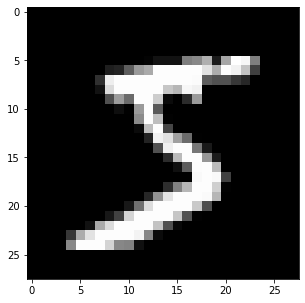

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Denoising

Como mencionamos antes, autoencoders como os que criamos até agora não são muito úteis na prática. No entanto, eles podem ser usados para remover ruídos de imagens com bastante sucesso apenas treinando a rede em imagens ruidosas. Podemos criar as imagens ruidosas adicionando ruído gaussiano às imagens de treinamento e recortando os valores entre 0 e 1.

> **Usaremos imagens ruidosas como entrada e as imagens limpas originais como targets.**

Abaixo está um exemplo de algumas imagens ruidosas e suas respectivas imagens originais.

<img src = 'notebook_ims/denoising.png' />


Como esse é um problema mais difícil para a rede, queremos utilizar mais camadas convolucionais, ou seja, redes mais profundas. Você também pode adicionar camadas adicionais. Sugiro começar com uma profundidade de 32 para as camadas convolucionais no codificador e as mesmas profundidades voltando para trás através do decodificador.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = torch.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


---
## Treinamento

Vamos realmente **adicionar ruído** às imagens e iremos utilizar essas imagens ruidosas para alimentar o nosso modelo. O modelo produzirá imagens reconstruídas com base na entrada ruidosa. Entretanto, queremos que ela produza imagens normais e pouco ruidosas e, assim, quando calcularmos a loss, ainda compararemos as saídas reconstruídas com as imagens originais!

Como estamos comparando valores de pixel em imagens de entrada e saída, será melhor usar uma loss destinada a uma tarefa de regressão. Portanto, neste caso, usaremos o `MSELoss` e compararemos as imagens de saída e imagens de entrada da seguinte maneira:
```
loss = criterion(outputs, images)
```

In [4]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.076841
Epoch: 2 	Training Loss: 0.791362
Epoch: 3 	Training Loss: 0.727004
Epoch: 4 	Training Loss: 0.690688
Epoch: 5 	Training Loss: 0.670832
Epoch: 6 	Training Loss: 0.656169
Epoch: 7 	Training Loss: 0.643791
Epoch: 8 	Training Loss: 0.635264
Epoch: 9 	Training Loss: 0.628907
Epoch: 10 	Training Loss: 0.623227
Epoch: 11 	Training Loss: 0.619052
Epoch: 12 	Training Loss: 0.616038
Epoch: 13 	Training Loss: 0.613053
Epoch: 14 	Training Loss: 0.610418
Epoch: 15 	Training Loss: 0.607729
Epoch: 16 	Training Loss: 0.605300
Epoch: 17 	Training Loss: 0.603927
Epoch: 18 	Training Loss: 0.602851
Epoch: 19 	Training Loss: 0.599893
Epoch: 20 	Training Loss: 0.598488


Notaram que o treinamento é extremamente lento? São muitos parâmetros para ajustar! Como tarefa para casa, pesquise sobre como implementar esse notebook utilizando uma GPU. Isso irá diminuir drasticamente o tempo de treinamento deste notebook.

## Verificando os resultados

Aqui, estamos adicionando ruído às imagens de teste e passando-as pelo autoencoder. Ele faz um excelente trabalho ao remover o ruído, mesmo que às vezes seja difícil dizer qual é o número original.

Vamos ver a imagem original, a imagem com ruído e sua versão após a remoção do ruído.

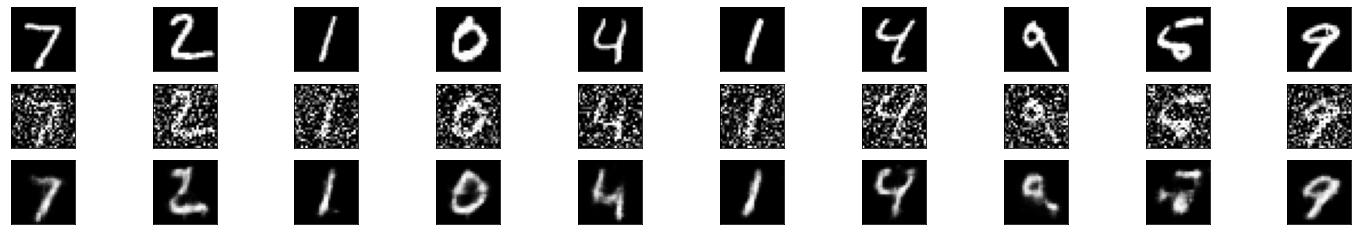

In [6]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([images, noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)